In [ ]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')

import pandas as pd
pd.set_option('display.max_columns', False)

import numpy as np
import seaborn as sns
import joblib
from datetime import datetime
from scipy import stats
from correlated_features import CorrelatedFeatures

from sklearn import set_config
from sklearn.linear_model import Lasso
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder

seed = 42

In [ ]:
def get_features(num_attribs: list,
                 nom_attribs: list,
                 ord_attribs: list,
                 best_estimator: object,
                 meta_transformer: bool = False) -> list:

    # continuous features
    no_corr_features = [feature
                        for feature in num_attribs
                        if feature not in best_estimator['columntransformer'].named_transformers_['num']['correlatedfeatures'].cols]
    continuous_features = [no_corr_features[i]
                           for i in best_estimator['columntransformer'].named_transformers_['num']['variancethreshold'].get_support(indices=True)]
    # nominal categorical features
    nominal_features = list(best_estimator['columntransformer'].named_transformers_['nom']['onehotencoder'].get_feature_names(nom_attribs))
    nominal_features = [nominal_features[i]
                        for i in best_estimator['columntransformer'].named_transformers_['nom']['variancethreshold'].get_support(indices=True)]
    # all features
    features = continuous_features + nominal_features + ord_attribs

    if meta_transformer:
        features = [features[i]
                    for i in best_estimator['selectfrommodel'].get_support(indices=True)]

    return features

## Flag selection
<a id='flag selection'></a>

In [ ]:
# model Selection flags
RF_flag = 1
GB_flag = 0

<a href='#model training'>**Link to model training box**</a>

## Data exploration

In [ ]:
raw_data = pd.read_csv('data/SB11_2019_clean1_nn.csv', skiprows= 0, encoding='ISO-8859-1')[:1000]
raw_data.columns = [x.lower() for x in raw_data.columns]
raw_data.shape

(566353, 50)

In [ ]:
raw_data.head()

,estu_nacionalidad,estu_genero,estu_fechanacimiento,estu_pais_reside,estu_tieneetnia,estu_etnia,estu_depto_reside,estu_mcpio_reside,fami_estratovivienda,fami_personashogar,fami_cuartoshogar,fami_educacionpadre,fami_educacionmadre,fami_trabajolaborpadre,fami_trabajolabormadre,fami_tieneinternet,fami_tieneserviciotv,fami_tienecomputador,fami_tienelavadora,fami_tienehornomicroogas,fami_tieneautomovil,fami_tienemotocicleta,fami_tieneconsolavideojuegos,fami_numlibros,fami_comelechederivados,fami_comecarnepescadohuevo,fami_comecerealfrutoslegumbre,fami_situacioneconomica,estu_dedicacionlecturadiaria,estu_dedicacioninternet,estu_horassemanatrabaja,estu_tiporemuneracion,cole_nombre_establecimiento,cole_genero,cole_naturaleza,cole_calendario,cole_bilingue,cole_caracter,cole_nombre_sede,cole_sede_principal,cole_area_ubicacion,cole_jornada,cole_mcpio_ubicacion,cole_depto_ubicacion,punt_global,percentil_global,estu_inse_individual,estu_nse_individual,estu_nse_establecimiento,estu_edad
0,COLOMBIA,F,2000-07-12,COLOMBIA,No,Ninguno,VALLE,CALI,Estrato 4,3 a 4,Cuatro,Técnica o tecnológica incompleta,Secundaria (Bachillerato) completa,"Trabaja como profesional (por ejemplo médico, ...","Trabaja en el hogar, no trabaja o estudia",Si,Si,Si,Si,Si,No,No,No,0 A 10 LIBROS,Todos o casi todos los días,3 a 5 veces por semana,Todos o casi todos los días,Mejor,Entre 1 y 2 horas,Entre 1 y 3 horas,0,No,INSTITUCIÓN EDUCATIVA TÉCNICA COMERCIAL HERNAN...,MIXTO,OFICIAL,A,N,TÉCNICO/ACADÉMICO,INSTITUCIÓN EDUCATIVA TÉCNICA COMERCIAL HERNAN...,S,URBANO,NOCHE,CALI,VALLE,235,29.0,58.199483,3.0,3.0,18.5
1,COLOMBIA,F,1998-03-23,COLOMBIA,No,Ninguno,VALLE,CALI,Estrato 3,7 a 8,Cuatro,Técnica o tecnológica completa,Secundaria (Bachillerato) completa,Trabaja por cuenta propia (por ejemplo plomero...,"Trabaja en el hogar, no trabaja o estudia",Si,Si,No,Si,No,No,No,No,11 A 25 LIBROS,3 a 5 veces por semana,Todos o casi todos los días,Nunca o rara vez comemos eso,Mejor,No leo por entretenimiento,Entre 1 y 3 horas,0,No,INSTITUCIÓN EDUCATIVA TÉCNICA COMERCIAL HERNAN...,MIXTO,OFICIAL,A,N,TÉCNICO/ACADÉMICO,INSTITUCIÓN EDUCATIVA TÉCNICA COMERCIAL HERNAN...,S,URBANO,NOCHE,CALI,VALLE,217,21.0,51.018527,2.0,3.0,20.8
2,COLOMBIA,M,2001-03-22,COLOMBIA,No,Ninguno,VALLE,CALI,Estrato 2,5 a 6,Cuatro,Primaria incompleta,Educación profesional completa,Es dueño de un negocio pequeño (tiene pocos em...,Tiene un trabajo de tipo auxiliar administrati...,Si,Si,No,Si,Si,No,No,Si,0 A 10 LIBROS,3 a 5 veces por semana,Nunca o rara vez comemos eso,Nunca o rara vez comemos eso,Igual,No leo por entretenimiento,30 minutos o menos,Más de 30 horas,"Si, en efectivo",INSTITUCIÓN EDUCATIVA TÉCNICA COMERCIAL HERNAN...,MIXTO,OFICIAL,A,N,TÉCNICO/ACADÉMICO,INSTITUCIÓN EDUCATIVA TÉCNICA COMERCIAL HERNAN...,S,URBANO,NOCHE,CALI,VALLE,246,34.0,50.855657,2.0,3.0,17.8
3,COLOMBIA,M,1994-06-16,COLOMBIA,No,Ninguno,VALLE,CALI,Estrato 2,3 a 4,Dos,Educación profesional completa,Educación profesional completa,"Trabaja como profesional (por ejemplo médico, ...","Trabaja en el hogar, no trabaja o estudia",Si,Si,Si,No,Si,No,Si,No,0 A 10 LIBROS,1 o 2 veces por semana,1 o 2 veces por semana,Nunca o rara vez comemos eso,Igual,No leo por entretenimiento,Más de 3 horas,Entre 11 y 20 horas,"Si, en efectivo",INSTITUCIÓN EDUCATIVA TÉCNICA COMERCIAL HERNAN...,MIXTO,OFICIAL,A,N,TÉCNICO/ACADÉMICO,INSTITUCIÓN EDUCATIVA TÉCNICA COMERCIAL HERNAN...,S,URBANO,NOCHE,CALI,VALLE,255,38.0,52.688203,3.0,3.0,24.6
4,COLOMBIA,F,2000-09-21,COLOMBIA,No,Ninguno,BOGOTA,BOGOTÁ D.C.,Estrato 6,3 a 4,Tres,Educación profesional completa,Educación profesional completa,"Trabaja como profesional (por ejemplo médico, ...","Trabaja en el hogar, no trabaja o estudia",Si,Si,Si,Si,Si,Si,No,Si,MÁS DE 100 LIBROS,Todos o casi todos los días,Todos o casi todos los días,Todos o casi todos los días,Igual,Entre 1 y 2 horas,Entre 1 y 3 horas,0,No,COL ANGLO COLOMBIANO ...,MIXTO,NO OFICIAL,B,S,ACADÉMICO,COL ANGLO COLOMBIANO ...,S,URBANO,COMPLETA,BOGOTÁ D.C.,BOGOTA,280,48.0,73.930829

In [ ]:
raw_data.isnull().sum()

estu_nacionalidad                    0
estu_genero                        103
estu_fechanacimiento                 0
estu_pais_reside                     0
estu_tieneetnia                      0
estu_etnia                           0
estu_depto_reside                    0
estu_mcpio_reside                    0
fami_estratovivienda             35845
fami_personashogar               16738
fami_cuartoshogar                17951
fami_educacionpadre              31796
fami_educacionmadre              31618
fami_trabajolaborpadre           19129
fami_trabajolabormadre           18292
fami_tieneinternet               32268
fami_tieneserviciotv             33255
fami_tienecomputador             17767
fami_tienelavadora               17569
fami_tienehornomicroogas         18390
fami_tieneautomovil              18941
fami_tienemotocicleta            17940
fami_tieneconsolavideojuegos     18942
fami_numlibros                   46306
fami_comelechederivados          38143
fami_comecarnepescadohuev

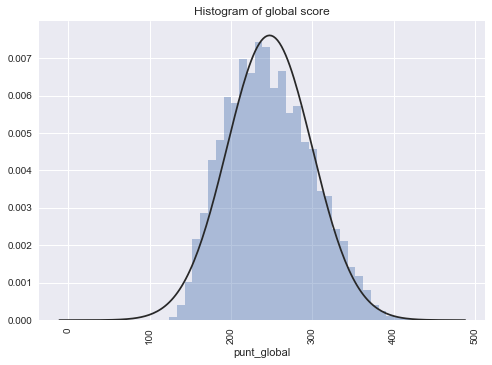

In [ ]:
sns.distplot(raw_data['punt_global'], fit=stats.norm, kde=False)
sns.set(color_codes=True)
plt.xticks(rotation=90)
plt.title("Histogram of global score")
plt.show()

## Train, Validation and Test Split

In [ ]:
X = raw_data.drop([
    'estu_fechanacimiento',
    'percentil_global',
    'estu_inse_individual',
    'estu_nse_individual',
    'estu_nse_establecimiento',
    'punt_global'],
    axis=1).copy()

y = raw_data['punt_global'].copy().values

Split the dataset into training, validation and test data sets.

In [ ]:
# train split
X_train, X_test_and_val, y_train, y_test_and_val = train_test_split(X, y, test_size=0.3, random_state=seed)
print(f'Training set shape {X_train.shape, y_train.shape}')
# validation and test split
X_val, X_test, y_val, y_test = train_test_split(X_test_and_val, y_test_and_val, test_size=0.333, random_state=seed)
print(f'Validation set shape {X_val.shape, y_val.shape}')
print(f'Test set shape {X_test.shape, y_test.shape}')

Training set shape ((396447, 44), (396447,))
Validation set shape ((113327, 44), (113327,))
Test set shape ((56579, 44), (56579,))


## Pipeline

In [ ]:
# store numerical attributes
num_attribs = list(X_train.select_dtypes(include=np.number))

# store ordinal and categorical attributes
ord_attribs = ['fami_estratovivienda',
               'fami_personashogar',
               'fami_cuartoshogar',
               'fami_educacionpadre',
               'fami_educacionmadre',
               'fami_numlibros',
               'fami_comelechederivados',
               'fami_comecarnepescadohuevo',
               'fami_comecerealfrutoslegumbre',
               'fami_situacioneconomica',
               'estu_dedicacionlecturadiaria',
               'estu_dedicacioninternet',
               'estu_horassemanatrabaja']

nom_attribs = [column for column in list(X_train.select_dtypes(include=object))
               if column not in ord_attribs]

In [ ]:
fami_estratovivienda = ['Sin Estrato', 'Estrato 1', 'Estrato 2', 'Estrato 3', 'Estrato 4', 'Estrato 5', 'Estrato 6']
fami_personashogar = ['1 a 2', '3 a 4', '5 a 6', '7 a 8', '9 o más']
fami_cuartoshogar = ['Uno', 'Dos', 'Tres', 'Cuatro', 'Cinco', 'Seis o mas']
fami_educacionpadre = ['No Aplica', 'No sabe', 'Ninguno', 'Primaria incompleta', 'Primaria completa', 'Secundaria (Bachillerato) incompleta', 'Secundaria (Bachillerato) completa', 'Técnica o tecnológica incompleta', 'Técnica o tecnológica completa', 'Educación profesional incompleta', 'Educación profesional completa', 'Postgrado']
fami_educacionmadre = ['No Aplica', 'No sabe', 'Ninguno', 'Primaria incompleta', 'Primaria completa', 'Secundaria (Bachillerato) incompleta', 'Secundaria (Bachillerato) completa', 'Técnica o tecnológica incompleta', 'Técnica o tecnológica completa', 'Educación profesional incompleta', 'Educación profesional completa', 'Postgrado']
fami_numlibros = ['0 A 10 LIBROS', '11 A 25 LIBROS', '26 A 100 LIBROS', 'MÁS DE 100 LIBROS']
fami_comelechederivados = ['Nunca o rara vez comemos eso', '1 o 2 veces por semana', '3 a 5 veces por semana', 'Todos o casi todos los días']
fami_comecarnepescadohuevo = ['Nunca o rara vez comemos eso', '1 o 2 veces por semana', '3 a 5 veces por semana', 'Todos o casi todos los días']
fami_comecerealfrutoslegumbre = ['Nunca o rara vez comemos eso', '1 o 2 veces por semana', '3 a 5 veces por semana', 'Todos o casi todos los días']
fami_situacioneconomica = ['Peor', 'Igual', 'Mejor']
estu_dedicacionlecturadiaria = ['No leo por entretenimiento', '30 minutos o menos', 'Entre 30 y 60 minutos', 'Entre 1 y 2 horas', 'Más de 2 horas']
estu_dedicacioninternet = ['No Navega Internet', '30 minutos o menos', 'Entre 30 y 60 minutos', 'Entre 1 y 3 horas', 'Más de 3 horas']
estu_horassemanatrabaja = ['0', 'Menos de 10 horas', 'Entre 11 y 20 horas', 'Entre 21 y 30 horas', 'Más de 30 horas']

In [ ]:
num_pipeline = make_pipeline(
    CorrelatedFeatures(threshold=0.7),
    SimpleImputer(strategy='constant', fill_value=0),
    StandardScaler(),
    VarianceThreshold(),
)

nom_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown='ignore'),
    VarianceThreshold(threshold=(.8 * (1 - .8))),
)

ord_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OrdinalEncoder(categories=[fami_estratovivienda,
                               fami_personashogar,
                               fami_cuartoshogar,
                               fami_educacionpadre,
                               fami_educacionmadre,
                               fami_numlibros,
                               fami_comelechederivados,
                               fami_comecarnepescadohuevo,
                               fami_comecerealfrutoslegumbre,
                               fami_situacioneconomica,
                               estu_dedicacionlecturadiaria,
                               estu_dedicacioninternet,
                               estu_horassemanatrabaja])
)

preprocessor_pipeline = ColumnTransformer(
    [('num', num_pipeline, num_attribs),
     ('nom', nom_pipeline, nom_attribs),
     ('ord', ord_pipeline, ord_attribs)],
    n_jobs=-1
)

In [ ]:
%%time
X_train_prepared = preprocessor_pipeline.fit_transform(X_train)
X_train_prepared.shape

CPU times: user 1.33 s, sys: 487 ms, total: 1.81 s
Wall time: 56min 2s


(396447, 40)

In [ ]:
%%time
X_val_prepared = preprocessor_pipeline.transform(X_val)
X_val_prepared.shape

CPU times: user 480 ms, sys: 167 ms, total: 647 ms
Wall time: 1.49 s


(113327, 40)

## Model training
<a id='model training'></a>

In [ ]:
%%time
# define models
models = {'LinearRegression': LinearRegression(n_jobs=-1),
          'RandomForestRegressor': RandomForestRegressor(random_state=seed, n_jobs=-1),
          'GradientBoostingRegressor': GradientBoostingRegressor(random_state=seed)}

# store results
y_pred = pd.DataFrame(columns=models.keys())
results = []

# train and evaluate models
for model in models.keys():
    start_time = datetime.now()
    # training each model
    models[model].fit(X_train_prepared, y_train)
    print(f'Model {model} -------> training time {datetime.now() - start_time}')
    # predict test for each model
    y_pred[model] = models[model].predict(X_val_prepared)
    # evaluate each model
    results.append({'RMSE': np.sqrt(mean_squared_error(y_val, y_pred[model])),
                    'MAE': mean_absolute_error(y_val, y_pred[model])})

Model LinearRegression -------> training time 0:00:00.000011
Model RandomForestRegressor -------> training time 0:00:00.000006
Model GradientBoostingRegressor -------> training time 0:00:00.000008
CPU times: user 11min 49s, sys: 4.87 s, total: 11min 54s
Wall time: 3min 49s


In [ ]:
# dataframe with metrics
results = pd.DataFrame(data=results, index=models.keys())
results

,RMSE,MAE
LinearRegression,43.791059,35.407064
RandomForestRegressor,41.345199,33.253776
GradientBoostingRegressor,41.043909,33.116118


In [ ]:
if RF_flag:
    model = RandomForestRegressor(random_state=seed, n_jobs=-1)
    param_grid = {
        'randomforestregressor__n_estimators': np.arange(50, 101, 25),
        'randomforestregressor__max_features': [None, 'sqrt', 'log2'],
        'randomforestregressor__max_depth': np.arange(1, 6, 1)
    }

In [ ]:
if GB_flag:
    model = GradientBoostingRegressor(random_state=seed)
    param_grid = {
        'gradientboostingregressor__learning_rate': np.arange(0.01, 0.11,0.01),
        'gradientboostingregressor__max_depth': np.arange(1, 4, 1)
    }

In [ ]:
full_pipeline = make_pipeline(
    preprocessor_pipeline,
    SelectFromModel(Lasso(alpha=5, max_iter=1000, random_state=seed)),
    model    
)

## Model tunning
<a id='model tunning'></a>

In [ ]:
gs_cv = GridSearchCV(estimator=full_pipeline, param_grid=param_grid, cv=5, 
                      scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
gs_cv.fit(X_train, y_train)
print("Tuned rg best params: {}".format(gs_cv.best_params_))

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 83.3min remaining: 125.0min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 83.4min finished


Tuned rg best params: {}


In [ ]:
cv_model = gs_cv.best_estimator_

In [ ]:
%%time
y_pred_train_cv = cv_model.predict(X_train)
y_pred_val_cv = cv_model.predict(X_val)
y_pred_test_cv = cv_model.predict(X_test)

CPU times: user 31.8 s, sys: 1.12 s, total: 32.9 s
Wall time: 11.6 s


#### Performance metrics

In [ ]:
results = pd.DataFrame([{
    'RMSE': np.sqrt(mean_squared_error(y_val, y_pred_val_cv)),
    'MAE': mean_absolute_error(y_val, y_pred_val_cv)
}])
results

,RMSE,MAE
0,47.089891,37.816155


#### Probability distribution

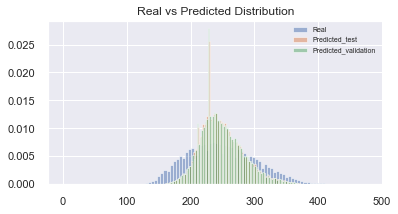

In [ ]:
plt.figure(figsize=(6, 3))
plt.hist(y_train, alpha=0.5, label='Real', density=True, bins=100)
plt.hist(pd.Series(y_pred_val_cv), alpha=0.5, label='Predicted_test', density=True, bins=100)
plt.hist(pd.Series(y_pred_test_cv), alpha=0.5, label='Predicted_validation', density=True, bins=100)
plt.legend(fontsize=7)
plt.title('Real vs Predicted Distribution')
plt.show()

<a href='#flag selection'>**Link to flag selection**</a>

#### Feature importance

In [ ]:
if RF_flag:
    features = get_features(num_attribs=num_attribs,
                 nom_attribs=nom_attribs,
                 ord_attribs=ord_attribs,
                 best_estimator=cv_model,
                 meta_transformer=True)
    feature_importance = cv_model['randomforestregressor'].feature_importances_
    importance_df = pd.DataFrame(sorted(zip(feature_importance, features), reverse=True), columns=['Importance', 'Feature'])

In [ ]:
if GB_flag:
    features = get_features(num_attribs=num_attribs,
                 nom_attribs=nom_attribs,
                 ord_attribs=ord_attribs,
                 best_estimator=cv_model,
                 meta_transformer=True)
    feature_importance = cv_model['gradientboostingregressor'].feature_importances_
    importance_df = pd.DataFrame(sorted(zip(feature_importance, features), reverse=True), columns=['Importance', 'Feature'])

In [ ]:
importance_df

,Importance,Feature
0,0.296609,fami_educacionmadre
1,0.153157,fami_educacionpadre
2,0.128314,fami_numlibros
3,0.107912,fami_estratovivienda
4,0.091096,estu_dedicacioninternet
5,0.082350,estu_dedicacionlecturadiaria
6,0.072560,fami_comelechederivados
7,0.068002,estu_horassemanatrabaja


## Model persistence

In [ ]:
if RF_flag:
    joblib.dump(cv_model, 'pipeline/rfregressor.pkl', compress=3)

In [ ]:
if GB_flag:
    joblib.dump(cv_model, 'pipeline/gbregressor.pkl', compress=3)

## Pipeline display

In [ ]:
set_config(display='diagram')

In [ ]:
full_pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('num',
                                                  Pipeline(steps=[('correlatedfeatures',
                                                                   CorrelatedFeatures()),
                                                                  ('simpleimputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('standardscaler',
                                                                   StandardScaler()),
                                                                  ('variancethreshold',
                                                                   VarianceThreshold())]),
                                                  ['estu_edad']),
                                                 ('nom',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   Sim...
                                                   'fami_comelechederivados',
                                                   'fami_comecarnepescadohuevo',
                                                   'fami_comecerealfrutoslegumbre',
                                                   'fami_situacioneconomica',
                                                   'estu_dedicacionlecturadiaria',
                                                   'estu_dedicacioninternet',
                                                   'estu_horassemanatrabaja'])])),
                ('selectfrommodel',
                 SelectFromModel(estimator=Lasso(alpha=5, max_iter=10000,
                                                 random_state=42))),
                ('randomforestregressor',
                 RandomForestRegressor(n_jobs=-1, random_state=42))])

In [ ]:
from sklearn.utils import estimator_html_repr
with open('pipeline/full_pipeline.html', 'w') as f:  
    f.write(estimator_html_repr(full_pipeline))

In [ ]:
set_config(display='text')